<h1> ASSIGNMENT 4 - Group A-72 </h1>
<h2> Unsupervised Learning Clustering and Recommendations</h2>

Johann Rajosefa 300300054
Kalala, Hilaire Junior 300289737

<ul>
    
<li> <b> Introduction </b> </li>

In this part of the assignment, I am going to perform studies 1 Similarity measures and 3 Content-Based Recommendation System.

<li><b>Dataset description : Anime recomendation</b></li>

<ul>

<li> This dataset is a collection of "Anime" or animated japanese shows, where each title is associated with a genre, its number of episodes, rating, etc. <br> 
Shape : 12294 rows and 8 columns <br>
Features :</li>

<ol>
<li>Unamed (Numerical) : Just an attribute to keep count of the anime list</li>
<li>anime_id (Numerical) : An unique id that identifies each anime</li>
<li>name (Categorical) : The title of each anime</li>
<li>genre (Categorical) : the list of genre the anime qualifies to</li>
<li>type (Categorical) : the type of show whether its a Movie, TV, or an OVA</li>
<li>episodes (Numerical) : the total number of episode the anime has</li>
<li>rating (Categorical) : the aglomerated rating of all viewers who watched the anime</li>
<li>members (Numerical) : the total number of loyal viewers the anime has</li>
    
</ol>

</ul>

<li><b> Preparing the data :</b> </li>

<ul>
    
<li>We start by doing data cleanning by checking issues in the dataset such as type errors or uniqueness errors. Then we impute missing data if there are some. We save it in a new file called fully_imputed_dataset.csv.</li>

</ul>

</ul>

In [33]:
# This is the same exact code as in assigment 3

import pandas as pd
import numpy as np
import requests
from io import StringIO
from sklearn.impute import KNNImputer
import re

# ==============================
# STEP 1: LOAD DATA FROM GITHUB
# ==============================
GITHUB_CSV_URL = "https://raw.githubusercontent.com/KugleBlitz007/CSI4142/refs/heads/main/Anime_clean.csv"
response = requests.get(GITHUB_CSV_URL)

if response.status_code == 200:
    data = pd.read_csv(StringIO(response.text))
    print("✅ Dataset successfully loaded from GitHub!")
else:
    print("❌ Failed to load dataset from GitHub.")
    exit()

# ==============================
# STEP 2: DATA CLEANING
# ==============================

def detect_data_issues(df):
    issues = {}

    # 1) Data Type Errors
    issues["Data_Type_Errors"] = df.map(lambda x: type(x).__name__)

    # 2) Range Errors (Negative or unrealistic values)
    issues["Range_Errors"] = df.apply(lambda col: col[(col < 0) | (col > col.quantile(0.99))] if col.dtype in [np.int64, np.float64] else np.nan)

    # 5) Uniqueness Errors (Duplicate IDs)
    if "ID" in df.columns:
        issues["Uniqueness_Errors"] = df[df.duplicated(subset=["ID"], keep=False)]

    # 6) Presence Errors (Missing values per column)
    issues["Presence_Errors"] = df.isnull().sum()

    # 7) Length Errors (Checking for excessively long values)
    issues["Length_Errors"] = df.apply(lambda col: col[col.astype(str).str.len() > 100] if col.dtype == 'object' else np.nan)
    
    # 9) Exact Duplicate Errors (Fully duplicated rows)
    issues["Exact_Duplicate_Errors"] = df[df.duplicated(keep=False)]

    # 10) Near Duplicate Errors
    issues["Near_Duplicate_Errors"] = df[df.duplicated(subset=df.columns.difference(["ID"]), keep=False)]

    return issues

# Run data cleaning checks
errors_found = detect_data_issues(data)

# Print detected issues
for error_type, issue_df in errors_found.items():
    print(f"\n{error_type}:")
    print(issue_df if isinstance(issue_df, pd.DataFrame) else issue_df.to_string())

# Dropping exact duplicates
data.drop_duplicates(inplace=True)

# ==============================
# STEP 3: IMPUTE MISSING VALUES (NUMERICAL & CATEGORICAL)
# ==============================

# Identify numerical and categorical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# KNN Imputation for Numerical Features**
imputer = KNNImputer(n_neighbors=5)  # Using 5 nearest neighbors
numerical_imputed = imputer.fit_transform(data[numerical_cols])  
data[numerical_cols] = pd.DataFrame(numerical_imputed, columns=numerical_cols)  # Convert back to DataFrame

print("✅ Numerical values imputed using KNN.")

# Mode Imputation for Categorical Features (Fixing inplace issue)**
for col in categorical_cols:
    if data[col].isnull().sum() > 0:
        mode_value = data[col].mode()[0]  # Get most frequent value
        data.loc[:, col] = data[col].fillna(mode_value)  

print("✅ Categorical values imputed using Mode (Most Frequent Value).")

# ==============================
# STEP 4: VERIFY IMPUTATION RESULTS
# ==============================
missing_after = data.isnull().sum()
missing_remaining = missing_after[missing_after > 0]

if missing_remaining.empty:
    print("\n✅ All missing values have been successfully imputed.")
else:
    print("\n⚠️ Warning: Some missing values remain after imputation:")
    print(missing_remaining)

# ==============================
# STEP 5: SAVE THE IMPUTED DATASET
# ==============================
imputed_filename = "fully_imputed_dataset.csv"
data.to_csv(imputed_filename, index=False)
#print(f"\n✅ Imputed dataset saved as {imputed_filename}")


✅ Dataset successfully loaded from GitHub!

Data_Type_Errors:
      Unnamed: 0 anime_id name genre type episodes rating members
0            int      int  str   str  str      int  float     int
1            int      int  str   str  str      int  float     int
2            int      int  str   str  str      int  float     int
3            int      int  str   str  str      int  float     int
4            int      int  str   str  str      int  float     int
...          ...      ...  ...   ...  ...      ...    ...     ...
12289        int      int  str   str  str      int  float     int
12290        int      int  str   str  str      int  float     int
12291        int      int  str   str  str      int  float     int
12292        int      int  str   str  str      int  float     int
12293        int      int  str   str  str      int  float     int

[12294 rows x 8 columns]

Range_Errors:
       Unnamed: 0  anime_id  name  genre  type  episodes  rating   members
0             NaN       NaN   



<ul><li><b>EDA and outlier detection</b></li></ul>



✅ Imputed dataset loaded successfully!


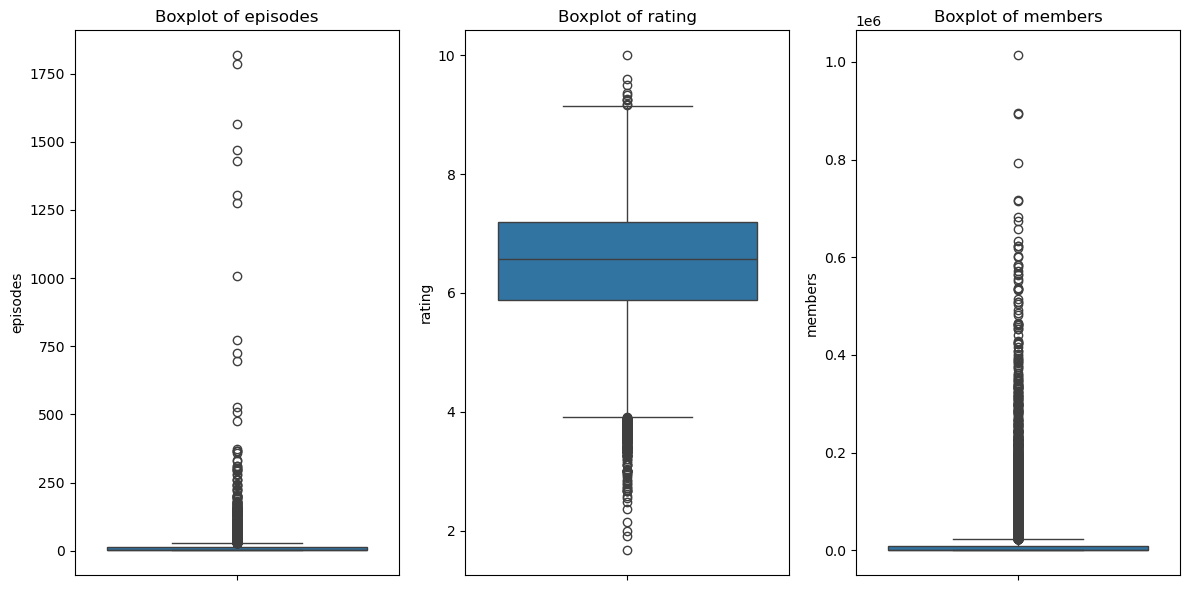

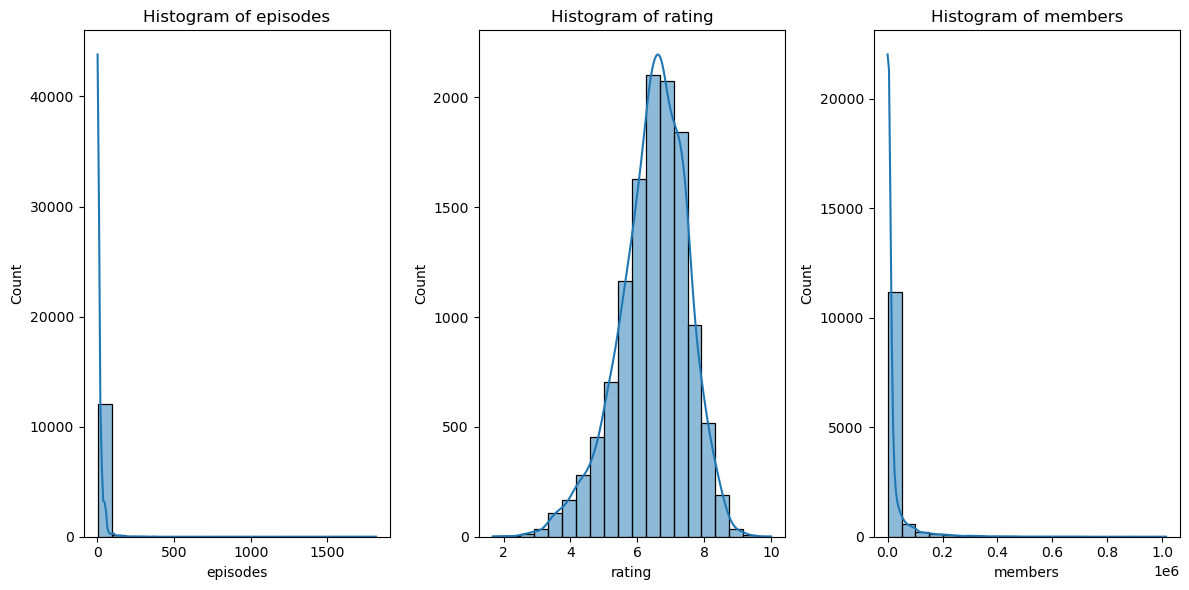

🔍 Detected 615 potential outliers using LOF.


In [36]:
#This is the same code as in assignement 3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import KNNImputer

# ==============================
# STEP 1: LOAD IMPUTED DATASET
# ==============================
imputed_filename = "fully_imputed_dataset.csv"
data = pd.read_csv(imputed_filename)
print("✅ Imputed dataset loaded successfully!")

# ==============================
# STEP 2: EXPLORATORY DATA ANALYSIS (EDA)
# ==============================

# Identify numerical features for analysis
numerical_cols = ["episodes", "rating", "members"]

# Boxplots to check outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=data[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

# Histograms for distribution analysis
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data[col], bins=20, kde=True)
    plt.title(f"Histogram of {col}")

plt.tight_layout()
plt.show()

# ==============================
# STEP 3: APPLY LOCAL OUTLIER FACTOR (LOF)
# ==============================

# LOF detects anomalies based on density differences
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Adjust contamination level
outlier_flags = lof.fit_predict(data[numerical_cols])

# LOF returns -1 for outliers, 1 for normal points
data["Outlier_Flag"] = np.where(outlier_flags == -1, True, False)

# Display detected outliers
outliers_detected = data[data["Outlier_Flag"]]
print(f"🔍 Detected {len(outliers_detected)} potential outliers using LOF.")




<ul>
<li><b>Feature engineering</b></li>
    In this part we will create new features that might be interresting:
<ul>
    <li>type_encoded : we encode the type of the anime in numerical format</li>
<li>is_longseries : if the anime has more than 100 episode, it will be considered long</li>
<li>rating_per_episode : rating divided by the number of episodes</li>
<li>main_genre : the first genre displayed</li>
<li>genre_count : how many genre the anime belongs to</li>
<li>popularity_level : separates popularity by low (less than 100000 people) medium (less than 500000 peple) high with more than that</li>
</ul>



</ul>



In [42]:
#This is the same code as in assignment 3

import pandas as pd

# ==============================
# STEP 1: LOAD CLEANED DATASET
# ==============================
decision_tree_filename = "fully_imputed_dataset.csv"
data = pd.read_csv(decision_tree_filename)
print("✅ Dataset loaded successfully!")

# ==============================
# STEP 2: CREATE NEW FEATURES
# ==============================

# 1. type_encoded (Movie=0, TV=1, Other=2)
data['type_encoded'] = data['type'].apply(lambda x: 0 if x == 'Movie' else (1 if x == 'TV' else 2))

# 2. is_longseries (True if episodes > 50)
data['is_longseries'] = data['episodes'].apply(lambda x: True if pd.to_numeric(x, errors='coerce') > 100 else False)

# Safely convert without overwriting logic
data['episodes_numeric'] = pd.to_numeric(data['episodes'], errors='coerce')
data['rating_per_episode'] = data.apply(
    lambda row: row['rating'] / row['episodes_numeric'] if pd.notnull(row['episodes_numeric']) and row['episodes_numeric'] > 0 else None,
    axis=1
)


# 4. main_genre (first genre in the comma-separated list)
data['main_genre'] = data['genre'].apply(lambda x: x.split(',')[0].strip() if pd.notnull(x) else None)

# 5. genre_count (number of genres listed)
data['genre_count'] = data['genre'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

# 6. popularity_level (Low < 100k, Medium 100k–500k, High > 500k)
def get_popularity_level(members):
    if members < 100000:
        return 'Low'
    elif members <= 500000:
        return 'Medium'
    else:
        return 'High'

data['popularity_level'] = data['members'].apply(get_popularity_level)

# ==============================
# STEP 3: SAVE UPDATED DATASET
# ==============================
updated_filename = "feature_engineered_dataset.csv"
data.to_csv(updated_filename, index=False)

# ==============================
# STEP 4: DISPLAY SUMMARY
# ==============================
print("\nNew Features Added:")
print("- type_encoded")
print("- is_longseries")
print("- rating_per_episode")
print("- main_genre")
print("- genre_count")
print("- popularity_level")


✅ Dataset loaded successfully!

New Features Added:
- type_encoded
- is_longseries
- rating_per_episode
- main_genre
- genre_count
- popularity_level


<h3><b>Studies 1 : Similarity </b></h3>

In this study, we will perform 5 similarity measures on 5 different attributes, using methods as follows: 

<ul>
<li>Jaccard similarity → genre</li>

<li>Euclidean distance → rating</li>

<li>Manhattan distance → episodes</li>

<li>Edit Distance → name</li>

<li>Cosine similarity → members as a vector </li>

</ul>

In [63]:
import pandas as pd
import numpy as np

# ==========================
# STEP 1: Load dataset
# ==========================
data = pd.read_csv("feature_engineered_dataset.csv")
print("✅ Dataset loaded!")

# ==========================
# STEP 2: Define utilities
# ==========================

# Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Simple edit distance
def simple_edit_distance(str1, str2):
    m, n = len(str1), len(str2)
    dp = [[0 for _ in range(n+1)] for _ in range(m+1)]

    for i in range(m+1):
        for j in range(n+1):
            if i == 0: dp[i][j] = j
            elif j == 0: dp[i][j] = i
            elif str1[i-1] == str2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j],    # Remove
                                   dp[i][j-1],    # Insert
                                   dp[i-1][j-1])  # Replace
    return dp[m][n]

# Normalize a column between 0 and 1
def normalize_column(col):
    return (col - col.min()) / (col.max() - col.min())

# ==========================
# STEP 3: Similarity Queries
# ==========================

# Query 1: Same genre as "Dragon Ball Z"
target = data[data["name"] == "Dragon Ball Z"].iloc[0]
target_genres = set(str(target["genre"]).split(", "))
data["genre_similarity"] = data["genre"].apply(
    lambda x: jaccard_similarity(set(str(x).split(", ")), target_genres)
)
top_genre_similar = data.sort_values(by="genre_similarity", ascending=False).head(10)

# Query 2: Similar rating to "One Punch Man"
target_rating = data[data["name"] == "One Punch Man"]["rating"].values[0]
data["rating_euclidean"] = data["rating"].apply(lambda x: (x - target_rating)**2)
top_rating_similar = data.sort_values(by="rating_euclidean").head(10)

# Query 3: Similar episode count to One Piece
target_episodes = data[data["name"] == "One Piece"]["episodes"].values[0]
data["episodes_manhattan"] = data["episodes"].apply(lambda x: abs(x - target_episodes))
top_episodes_similar = data.sort_values(by="episodes_manhattan").head(10)

# Query 4: Similar name to "JoJo no Kimyou na Bouken"
target_name = "JoJo no Kimyou na Bouken"
data["name_edit_distance"] = data["name"].apply(lambda x: simple_edit_distance(str(x), target_name))
top_name_similar = data.sort_values(by="name_edit_distance").head(10)

# Query 5: Similar number of members (using normalized absolute difference)
data["members_norm"] = normalize_column(data["members"])
target_members = data[data["name"] == "Mob Psycho 100"]["members_norm"].values[0]
data["members_similarity"] = data["members_norm"].apply(lambda x: 1 - abs(x - target_members))
top_members_similar = data.sort_values(by="members_similarity", ascending=False).head(10)

# ==========================
# STEP 4: Display Results
# ==========================
def show_top(df, title):
    print(f"\n🔍 Top 10 results for: {title}")
    display(df[["name", "genre", "episodes", "rating", "members"]].head(10))

print("Show me animes of the same genre as Dragon Ball Z")
show_top(top_genre_similar, "Genre Similarity (Jaccard)")

print("Show me animes of the same rating as One punch man")
show_top(top_rating_similar, "Rating Similarity (Euclidean)")

print("Show me animes of the same episode count as One Piece")
show_top(top_episodes_similar, "Episode Count Similarity (Manhattan)")

print("Show me animes of the same name as JoJo no Kimyou na Bouken")
show_top(top_name_similar, "Title Similarity (Edit Distance)")

print("Show me animes of the same popularity as Mob Psycho 100")
show_top(top_members_similar, "Popularity Similarity (Normalized Difference)")


✅ Dataset loaded!
Show me animes of the same genre as Dragon Ball Z

🔍 Top 10 results for: Genre Similarity (Jaccard)


,name,genre,episodes,rating,members
1409,Dragon Ball Z Movie 15: Fukkatsu no F,"Action, Adventure, Comedy, Fantasy, Martial Ar...",1.0,7.55,41051.0
588,Dragon Ball Kai,"Action, Adventure, Comedy, Fantasy, Martial Ar...",97.0,7.95,116832.0
3203,Dragon Ball Z: Summer Vacation Special,"Action, Adventure, Comedy, Fantasy, Martial Ar...",1.0,7.05,4251.0
1930,Dragon Ball Super,"Action, Adventure, Comedy, Fantasy, Martial Ar...",13.0,7.40,111443.0
4314,Dragon Ball GT: Goku Gaiden! Yuuki no Akashi w...,"Action, Adventure, Comedy, Fantasy, Martial Ar...",1.0,6.75,32853.0
515,Dragon Ball Kai (2014),"Action, Adventure, Comedy, Fantasy, Martial Ar...",61.0,8.01,42666.0
5999,Dragon Ball Z Movie 11: Super Senshi Gekiha!! ...,"Action, Adventure, Comedy, Fantasy, Martial Ar...",1.0,6.28,49949.0
206,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar...",291.0,8.32,375662.0
4275,Dragon Ball Z: Atsumare! Gokuu World,"Action, Adventure, Comedy, Fantasy, Martial Ar...",1.0,6.76,10044.0
1931,Dragon Ball: Episode of Bardock,"Action, Adventure, Comedy, Fantasy, Martial Ar...",1.0,7.40,29030.0


Show me animes of the same rating as One punch man

🔍 Top 10 results for: Rating Similarity (Euclidean)


,name,genre,episodes,rating,members
22,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26.0,8.82,486824.0
23,One Punch Man,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",12.0,8.82,552458.0
20,Hajime no Ippo,"Comedy, Drama, Shounen, Sports",75.0,8.83,157670.0
21,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...,"Action, Drama, Historical, Martial Arts, Roman...",4.0,8.83,129307.0
24,Mononoke Hime,"Action, Adventure, Fantasy",1.0,8.81,339556.0
25,Suzumiya Haruhi no Shoushitsu,"Comedy, Mystery, Romance, School, Sci-Fi, Supe...",1.0,8.81,240297.0
19,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",25.0,8.83,715151.0
26,Monogatari Series: Second Season,"Comedy, Mystery, Romance, Supernatural, Vampire",26.0,8.80,205959.0
27,Mushishi Zoku Shou,"Adventure, Fantasy, Historical, Mystery, Seine...",10.0,8.80,101351.0
18,Ookami Kodomo no Ame to Yuki,"Fantasy, Slice of Life",1.0,8.84,226193.0


Show me animes of the same episode count as One Piece

🔍 Top 10 results for: Episode Count Similarity (Manhattan)


,name,genre,episodes,rating,members
10880,Zhongguo Jingqi Xiansheng,"Comedy, Supernatural, Thriller",63.0,6.96,386.0
4161,Mahou no Princess Minky Momo,"Magic, Shoujo",63.0,6.79,2229.0
390,City Hunter 2,"Action, Comedy, Mystery, Shounen",63.0,8.12,8199.0
9263,Kobo-chan,"Comedy, Kids, Slice of Life",63.0,6.72,160.0
74,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",63.0,8.58,504862.0
9228,Kimoshiba,Comedy,63.0,7.00,81.0
4411,Ohayo! Spank,"Comedy, Slice of Life",63.0,6.73,981.0
5226,Rokushin Gattai GodMars,"Action, Mecha, Sci-Fi, Space",64.0,6.52,917.0
4444,Dragon Ball GT,"Action, Adventure, Comedy, Fantasy, Magic, Sci...",64.0,6.72,226625.0
2460,Puchimas!: Petit iDOLM@STER,"Comedy, Slice of Life",64.0,7.26,9208.0


Show me animes of the same name as JoJo no Kimyou na Bouken

🔍 Top 10 results for: Title Similarity (Edit Distance)


,name,genre,episodes,rating,members
1668,JoJo no Kimyou na Bouken,"Adventure, Drama, Fantasy, Horror, Shounen, Su...",6.0,7.47,24523.0
95,JoJo no Kimyou na Bouken (TV),"Action, Adventure, Shounen, Supernatural, Vampire",26.0,8.51,190197.0
9758,Noel no Fushigi na Bouken,"Adventure, Comedy, Fantasy",1.0,5.38,133.0
2581,JoJo no Kimyou na Bouken: Adventure,"Adventure, Drama, Fantasy, Horror, Shounen, Su...",7.0,7.22,20337.0
8327,Chibikko Kamu no Bouken,"Adventure, Kids",1.0,7.25,55.0
2861,Tom Sawyer no Bouken,"Adventure, Drama, Historical, Slice of Life",49.0,7.15,2322.0
8915,Hoshigari Hime no Bouken,"Fantasy, Kids",1.0,5.64,60.0
461,Magi: Sinbad no Bouken,"Action, Adventure, Fantasy, Magic, Shounen",5.0,8.06,52351.0
8599,Gamba to Kawauso no Bouken,"Adventure, Kids",1.0,6.50,95.0
3704,Peter Pan no Bouken,"Adventure, Fantasy",41.0,6.91,2146.0


Show me animes of the same popularity as Mob Psycho 100

🔍 Top 10 results for: Popularity Similarity (Normalized Difference)


,name,genre,episodes,rating,members
82,Mob Psycho 100,"Action, Comedy, Slice of Life, Supernatural",12.0,8.55,193716.0
1476,Shimoneta to Iu Gainen ga Sonzai Shinai Taikut...,"Comedy, Ecchi, School",12.0,7.53,193822.0
668,Yamada-kun to 7-nin no Majo (TV),"Comedy, Harem, Mystery, Romance, School, Shoun...",12.0,7.91,193566.0
397,Kami nomi zo Shiru Sekai II,"Comedy, Harem, Romance, Shounen, Supernatural",12.0,8.12,194300.0
116,Ghost in the Shell: Stand Alone Complex,"Action, Mecha, Military, Police, Sci-Fi, Seinen",26.0,8.47,194491.0
294,Evangelion: 1.0 You Are (Not) Alone,"Action, Mecha, Sci-Fi",1.0,8.21,194561.0
1078,Air Gear,"Action, Comedy, Ecchi, Shounen, Sports",25.0,7.69,194611.0
2696,B Gata H Kei,"Comedy, Ecchi, Romance, School, Seinen",12.0,7.18,192719.0
1830,Ore no Imouto ga Konnani Kawaii Wake ga Nai.,"Comedy, Seinen, Slice of Life",13.0,7.43,194791.0
80,Usagi Drop,"Josei, Slice of Life",11.0,8.56,194855.0


<h4>Comment on the results of Studies 1</h4>

The results from Study 1 highlight the strengths and limitations of each similarity measure. The edit distance on titles proved effective in identifying sequels and alternate versions of the same anime, such as JoJo no Kimyou na Bouken, although it occasionally included unrelated titles with similar wording.<br>
Manhattan distance on episode count successfully grouped animes of similar length. <br>
Euclidean similarity accurately retrieved highly rated animes close to One Punch Man.<br>
The most contextually relevant recommendations came from Jaccard similarity on genres, which returned animes closely aligned with Dragon Ball Z in terms of theme and content. <br>
Overall, the study shows that while individual similarity measures can surface interesting patterns, combining content-based features like genre with numerical ones such as rating or episodes could offer more meaningful recommendations.

<h3><b>Studies 3</h3></b>

We have developed those 2 heuristic values :

<ul>

<li>Top 10 recommendations from Heuristic 1 (genre + rating)</li>

<li>Top 10 recommendations from Heuristic 2 (genre + episodes + members)</li>

</ul>



In [73]:
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv("feature_engineered_dataset.csv")

# =========================
# Utility Functions
# =========================

# Jaccard similarity for genre
def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

# Euclidean distance
def euclidean(a, b):
    return (a - b)**2

# Manhattan distance
def manhattan(a, b):
    return abs(a - b)

# Normalize between 0 and 1
def normalize_column(col):
    return (col - col.min()) / (col.max() - col.min())

# =========================
# Recommendation Heuristics
# =========================

def heuristic_1(row, target_genre, target_rating):
    genre_sim = jaccard_similarity(set(str(row["genre"]).split(", ")), target_genre)
    rating_dist = euclidean(row["rating"], target_rating)
    score = genre_sim - rating_dist  # high genre sim, low distance = better
    return score

def heuristic_2(row, target_genre, target_episodes, target_members_norm):
    genre_sim = jaccard_similarity(set(str(row["genre"]).split(", ")), target_genre)
    episode_dist = manhattan(row["episodes"], target_episodes)
    member_norm = abs(row["members_norm"] - target_members_norm)
    score = genre_sim - (0.5 * episode_dist + 0.5 * member_norm)  # weighted penalty
    return score

# Normalize members for Heuristic 2
data["members_norm"] = normalize_column(data["members"])

# =========================
# Recommend Function
# =========================

def recommend(anime_title):
    if anime_title not in data["name"].values:
        print(f"❌ '{anime_title}' not found in dataset.")
        return

    target = data[data["name"] == anime_title].iloc[0]
    target_genre = set(str(target["genre"]).split(", "))
    target_rating = target["rating"]
    target_episodes = target["episodes"]
    target_members_norm = target["members_norm"]

    df = data.copy()
    df["heuristic_1_score"] = df.apply(lambda row: heuristic_1(row, target_genre, target_rating), axis=1)
    df["heuristic_2_score"] = df.apply(lambda row: heuristic_2(row, target_genre, target_episodes, target_members_norm), axis=1)

    print(f"\n🔹 Heuristic 1 (Genre + Rating) recommendations for: {anime_title}")
    display(df[df["name"] != anime_title].sort_values(by="heuristic_1_score", ascending=False)
            [["name", "genre", "rating", "heuristic_1_score"]].head(10))

    print(f"\n🔹 Heuristic 2 (Genre + Episodes + Members) recommendations for: {anime_title}")
    display(df[df["name"] != anime_title].sort_values(by="heuristic_2_score", ascending=False)
            [["name", "genre", "episodes", "members", "heuristic_2_score"]].head(10))

# =========================
# Run Sample Queries
# =========================

sample_titles = [
    "Dragon Ball Z",
    "Naruto",
    "Mob Psycho 100"
]

for title in sample_titles:
    recommend(title)



🔹 Heuristic 1 (Genre + Rating) recommendations for: Dragon Ball Z


,name,genre,rating,heuristic_1_score
515,Dragon Ball Kai (2014),"Action, Adventure, Comedy, Fantasy, Martial Ar...",8.01,0.903900
588,Dragon Ball Kai,"Action, Adventure, Comedy, Fantasy, Martial Ar...",7.95,0.863100
352,One Piece Film: Strong World Episode 0,"Action, Adventure, Comedy, Fantasy, Shounen, S...",8.16,0.831543
346,Dragon Ball,"Adventure, Comedy, Fantasy, Martial Arts, Shou...",8.16,0.831543
231,One Piece: Episode of Merry - Mou Hitori no Na...,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.29,0.749100
241,One Piece: Episode of Nami - Koukaishi no Nami...,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.27,0.747500
74,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.58,0.682400
753,One Piece: Episode of Luffy - Hand Island no B...,"Action, Adventure, Comedy, Fantasy, Shounen, S...",7.86,0.645543
486,Boruto: Naruto the Movie,"Action, Comedy, Martial Arts, Shounen, Super P...",8.03,0.630186
212,One Piece Film: Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.32,0.625000



🔹 Heuristic 2 (Genre + Episodes + Members) recommendations for: Dragon Ball Z


,name,genre,episodes,members,heuristic_2_score
3314,Tottoko Hamtarou,"Adventure, Comedy, Kids",296.0,29433.0,-2.420739
3208,Ikkyuu-san,"Comedy, Historical, Kids",296.0,720.0,-2.573788
8478,Dotanba no Manners,"Comedy, Slice of Life",283.0,75.0,-4.060217
5102,Kabatotto,Comedy,300.0,240.0,-4.542278
9472,Manga Hajimete Monogatari,"Adventure, Comedy, Historical",305.0,169.0,-6.935170
5050,Cookin&#039; Idol Ai! Mai! Main!,"Comedy, Kids",305.0,956.0,-7.059782
1834,Pokemon,"Action, Adventure, Comedy, Fantasy, Kids",276.0,229157.0,-7.072247
8974,Instant History,Historical,312.0,155.0,-10.685177
9893,Otogi Manga Calendar,Historical,312.0,146.0,-10.685182
9760,Non-tan to Issho,Kids,263.0,95.0,-14.185207



🔹 Heuristic 1 (Genre + Rating) recommendations for: Naruto


,name,genre,rating,heuristic_1_score
1103,Boruto: Naruto the Movie - Naruto ga Hokage ni...,"Action, Comedy, Martial Arts, Shounen, Super P...",7.68,0.983100
615,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",7.94,0.983100
486,Boruto: Naruto the Movie,"Action, Comedy, Martial Arts, Shounen, Super P...",8.03,0.951600
1343,Naruto x UT,"Action, Comedy, Martial Arts, Shounen, Super P...",7.58,0.947100
1472,Naruto: Shippuuden Movie 4 - The Lost Tower,"Action, Comedy, Martial Arts, Shounen, Super P...",7.53,0.921600
1573,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,"Action, Comedy, Martial Arts, Shounen, Super P...",7.50,0.903900
2458,Naruto Shippuuden: Sunny Side Battle,"Action, Comedy, Martial Arts, Shounen, Super P...",7.26,0.697500
588,Dragon Ball Kai,"Action, Adventure, Comedy, Fantasy, Martial Ar...",7.95,0.694686
1209,Medaka Box Abnormal,"Action, Comedy, Ecchi, Martial Arts, School, S...",7.63,0.681886
515,Dragon Ball Kai (2014),"Action, Adventure, Comedy, Fantasy, Martial Ar...",8.01,0.674286



🔹 Heuristic 2 (Genre + Episodes + Members) recommendations for: Naruto


,name,genre,episodes,members,heuristic_2_score
1371,Yu☆Gi☆Oh! Duel Monsters,"Adventure, Game, Shounen",224.0,132099.0,-2.128960
8699,Good Morning!!! Doronjo,"Comedy, Parody",225.0,135.0,-2.670227
9571,Miracle! Mimika,"Kids, Slice of Life",225.0,145.0,-2.836889
175,Katekyo Hitman Reborn!,"Action, Comedy, Shounen, Super Power",203.0,258103.0,-7.909680
6387,Mazinger ZIP!,"Comedy, Mecha",237.0,273.0,-8.670159
12,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",201.0,336376.0,-9.337747
8992,Itazura Tenshi Chippo-chan,"Comedy, Kids",240.0,82.0,-10.170254
9315,Kotori Samba,"Comedy, Music",240.0,74.0,-10.170258
5563,O-bake no... Holly,"Comedy, Fantasy, Kids, Magic",200.0,194.0,-10.211865
5151,Parasol Henbei,"Adventure, Comedy, Fantasy, Kids, Magic",200.0,229.0,-10.225737



🔹 Heuristic 1 (Genre + Rating) recommendations for: Mob Psycho 100


,name,genre,rating,heuristic_1_score
99,Barakamon,"Comedy, Slice of Life",8.50,0.497500
478,Durarara!! Specials,"Action, Comedy, Supernatural",8.04,0.489900
10718,Warera Salaryman Tou,"Comedy, Slice of Life",8.67,0.485600
159,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",8.39,0.474400
347,Hanada Shounen-shi,"Comedy, Drama, Slice of Life, Supernatural",8.16,0.447900
84,Baccano!,"Action, Comedy, Historical, Mystery, Seinen, S...",8.54,0.428471
76,JoJo no Kimyou na Bouken: Diamond wa Kudakenai,"Action, Adventure, Comedy, Drama, Shounen, Sup...",8.57,0.428171
97,Nichijou,"Comedy, School, Slice of Life",8.52,0.399100
94,Fate/Zero,"Action, Fantasy, Supernatural",8.51,0.398400
57,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,"Drama, Slice of Life, Supernatural",8.62,0.395100



🔹 Heuristic 2 (Genre + Episodes + Members) recommendations for: Mob Psycho 100


,name,genre,episodes,members,heuristic_2_score
8791,Heibai Wushang,"Action, Comedy, Supernatural",12.0,216.0,0.654578
1532,Kamichu!,"Comedy, Drama, Slice of Life, Supernatural",12.0,33053.0,0.520771
4410,Nekogami Yaoyorozu,"Comedy, Seinen, Slice of Life, Supernatural",12.0,12486.0,0.510628
927,Bungou Stray Dogs,"Action, Comedy, Mystery, Seinen, Supernatural",12.0,187805.0,0.497085
99,Barakamon,"Comedy, Slice of Life",12.0,225927.0,0.484115
2150,Inou-Battle wa Nichijou-kei no Naka de,"Comedy, Romance, School, Slice of Life, Supern...",12.0,144370.0,0.475666
2133,Tamako Market,"Comedy, Slice of Life",12.0,128529.0,0.467854
3788,C³,"Action, Comedy, Ecchi, School, Supernatural",12.0,100425.0,0.453995
1161,Flying Witch,"Comedy, Magic, Shounen, Slice of Life, Superna...",12.0,95933.0,0.451779
5878,Soul Eater NOT!,"Action, Comedy, Ecchi, Shounen, Supernatural",12.0,92269.0,0.449972


<h4>Comment on the results of Studies 3</h4>

The results shows a clear difference in effectiveness between the two heuristics.<br> Heuristic 1, which combines genre similarity with rating proximity, consistently produced thematically relevant and high-quality recommendations. For instance, queries for Dragon Ball Z and Naruto returned sequels, spin-offs, and entries from the same universe, while results for Mob Psycho 100 captured emotionally and stylistically similar series.<br>
In contrast, Heuristic 2, which is based on genre, episode count, and popularity (members), often prioritized structural similarities over content relevance. While Heuristic 2 showed some promise in short-form series like Mob Psycho 100, it generally failed to capture narrative or emotional consistency.<br>
Overall, Heuristic 1 proved to be the more effective content-based strategy for recommending anime that aligns with viewer preferences and expectations.


References : some same as assignment 3
- ChatGPT 4o
- https://www.geeksforgeeks.org
- https://scikit-learn.org/stable/supervised_learning.
- https://www.w3schools.com/python/pandas/default.asp
- https://www.w3schools.com/python/numpy/numpy_intro.asp